In [1]:
import  plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pickle
import copy
from collections import OrderedDict
from math import pi

In [6]:
exp_name = 'trajectories_test'
ys = ['P(S+)','P(E+)','P(feas)']
d = {}
plot_dir = '../../outputs/{}/pom_sensitivity/'.format(exp_name)
for y in ys:
    d[y] = pickle.load(open('{}/baseline_pom_sensitivity_{}.pkl'.format(plot_dir, y), 'rb'))

## Variable importance

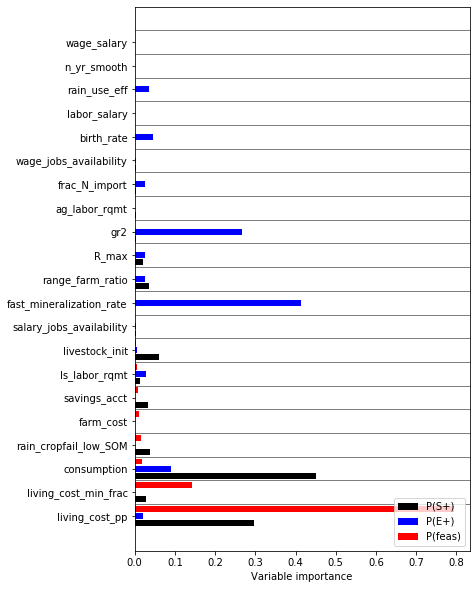

In [3]:
for yi, y in enumerate(ys):
    o_y = copy.deepcopy(d[y]['var_imps_df'])
    o_y.columns.values[o_y.columns=='importance'] = 'importance_{}'.format(y)
    if yi==0:
        all_df = o_y
    else:
        all_df = all_df.merge(o_y, on=('key','variable'))
all_df = all_df.sort_values('importance_{}'.format(y), ascending=False)
all_df = all_df.reset_index()

# create the figure
fig, ax = plt.subplots(figsize=(6,10))
xs = np.array(all_df.index)
colors=['k','b','r']
for yi, y in enumerate(ys):
    ax.barh(y=xs-0.3+0.3*yi, width=all_df['importance_{}'.format(y)], color=colors[yi], height=0.25,
           label=y)
ax.set_yticks(xs)
ax.set_yticklabels(np.array(all_df['variable']))#, rotation=90)
ax.legend(loc='lower right')
for xi, x in enumerate(xs):
    ax.axhline(x+0.5, color='k', lw=0.5)
ax.set_xlabel('Variable importance')
fig.savefig('{}/variable_importance.png'.format(plot_dir))

## PDPs

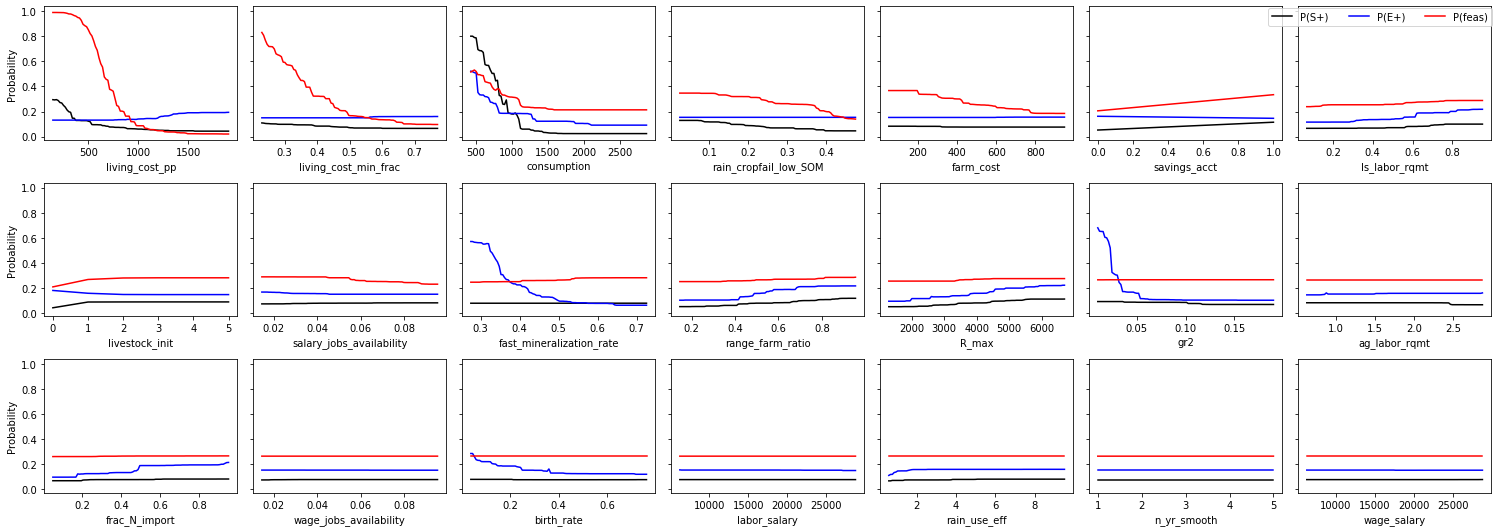

In [16]:
nplot = all_df.shape[0]
varz = np.array(all_df.variable)
ncol=7
nrow=int(np.ceil(nplot/ncol))
fig, axs = plt.subplots(nrow,ncol,figsize=(3*ncol,2.5*nrow), sharey=True)
ax_flat = axs.flatten()

for vi, vari in enumerate(varz):
    for yi, y in enumerate(ys):
        x_plot = np.array(d[y]['pdp_datas'][vari]['x']).mean(axis=0)
        y_plot = np.mean(np.array(d[y]['pdp_datas'][vari]['y']), axis=0)
        ax_flat[vi].plot(x_plot, y_plot, color=colors[yi])
    # formatting
    ax_flat[vi].set_xlabel(vari)
    
for axi in ax_flat[(vi+1):]:
    axi.remove()
    
lg = fig.legend(ys, bbox_to_anchor=[0.99,0.98], loc = 'upper right', ncol=3)
for axi in axs[:,0]:
    axi.set_ylabel('Probability')
fig.tight_layout()
fig.savefig('{}/pdps.png'.format(plot_dir),dpi=200)

## fit of models

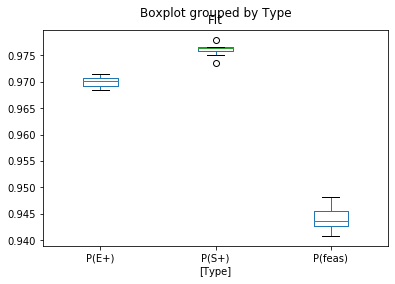

In [17]:
fit_all = []
name_all = []
for y in ys:
    fit_all.append(d[y]['fit'])
    name_all.append([y]*len(d[y]['fit']))

fit_all = [fiti for subl in fit_all for fiti in subl]
name_all = [namei for subl in name_all for namei in subl]
fit_df = pd.DataFrame.from_dict({'Type':name_all,'Fit':fit_all})

fig, ax = plt.subplots(1,1,figsize=(6,4))
fit_df.boxplot(ax=ax, by='Type')
ax.grid(False)
fig.savefig('{}/error_boxplot.png'.format(plot_dir))